In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

## 데이터 살펴보기

* Cookie: Randomly generated customer id enabling us to tie subsequent visits back to the same customer
* Timestamp: Date and time when the visit took place
* Interaction: Categorical variable indicating the type of interaction that took place
* Conversion: Boolean variable indicating whether a conversion took place
* Conversion Value: Value of the potential conversion event
* Channel: The marketing channel that brought the customer to our site


In [4]:
df = pd.read_csv('attribution_data.csv')
df

,cookie,time,interaction,conversion,conversion_value,channel
0,00000FkCnDfDDf0iC97iC703B,2018-07-03T13:02:11Z,impression,0,0.0,Instagram
1,00000FkCnDfDDf0iC97iC703B,2018-07-17T19:15:07Z,impression,0,0.0,Online Display
2,00000FkCnDfDDf0iC97iC703B,2018-07-24T15:51:46Z,impression,0,0.0,Online Display
3,00000FkCnDfDDf0iC97iC703B,2018-07-29T07:44:51Z,impression,0,0.0,Online Display
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03T09:44:57Z,impression,0,0.0,Paid Search
...,...,...,...,...,...,...
586732,ooooEiB0CCoEf9fiiC90Dfhfk,2018-07-12T23:50:45Z,impression,0,0.0,Online Display
586733,ooooEiB0CCoEf9fiiC90Dfhfk,2018-07-12T23:50:54Z,impression,0,0.0,Online Display
586734,ooooiBh70D3k3BfAhDFfii9h7,2018-07-03T12:57:25Z,impression,0,0.0,Paid Search
586735,ooooiBh70D3k3BfAhDFfii9h7,2018-07-19T08:17:59Z,impression,0,0.0,Online Video


# 각 채널로 움직이는 전이확률(Transition Probability) 구하기

In [8]:
df.channel.unique().tolist()

['Instagram', 'Online Display', 'Paid Search', 'Facebook', 'Online Video']

In [5]:
df_paths = (
    df.groupby('cookie')['channel']
    .aggregate(lambda x: x.unique().tolist())
    .reset_index()
)
df_paths

,cookie,channel
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display]"
1,0000nACkD9nFkBBDECD3ki00E,[Paid Search]
2,0003EfE37E93D0BC03iBhBBhF,[Paid Search]
3,00073CFE3FoFCn70fBhB3kfon,[Instagram]
4,00079hhBkDF3k3kDkiFi9EFAD,[Paid Search]
...,...,...
240103,ooooE0hkAFBkED90ChDDiBFAf,[Online Display]
240104,ooooEBE0o0D97ACAAAnDoi3F0,[Online Display]
240105,ooooEiB0CCoEf9fiiC90Dfhfk,[Online Display]
240106,ooooiBh70D3k3BfAhDFfii9h7,"[Paid Search, Online Video]"


### 유저별 전환 여부

In [9]:
df_last_interaction = df.drop_duplicates('cookie', keep='last')[['cookie', 'conversion']]
df_last_interaction.head()

,cookie,conversion
3,00000FkCnDfDDf0iC97iC703B,0
9,0000nACkD9nFkBBDECD3ki00E,0
14,0003EfE37E93D0BC03iBhBBhF,0
15,00073CFE3FoFCn70fBhB3kfon,0
16,00079hhBkDF3k3kDkiFi9EFAD,0


In [10]:
df_paths = pd.merge(df_paths, df_last_interaction, how='left', on='cookie')
df_paths

,cookie,channel,conversion
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display]",0
1,0000nACkD9nFkBBDECD3ki00E,[Paid Search],0
2,0003EfE37E93D0BC03iBhBBhF,[Paid Search],0
3,00073CFE3FoFCn70fBhB3kfon,[Instagram],0
4,00079hhBkDF3k3kDkiFi9EFAD,[Paid Search],0
...,...,...,...
240103,ooooE0hkAFBkED90ChDDiBFAf,[Online Display],0
240104,ooooEBE0o0D97ACAAAnDoi3F0,[Online Display],0
240105,ooooEiB0CCoEf9fiiC90Dfhfk,[Online Display],0
240106,ooooiBh70D3k3BfAhDFfii9h7,"[Paid Search, Online Video]",0


### Markov Chain의 State를 만들자

State 종류
* Start: 첫 시작 
* Instagram: 인스타그램 광고
* Paid Search: 유료 검색 광고
* Facebook: 페이스북 광고
* Online Video: 비디오형 광고
* Online Display: 배너 노출 광고
* Conversion: 전환 성공 (구매 완료)
* Null: 전환 실패 (구매 없이 나감)

In [11]:
df_paths['paths'] = (
    df_paths.apply(
        lambda x: ['Start'] + x.channel + ['Null'] if x.conversion == 0
        else ['Start'] + x.channel + ['Conversion'], axis=1
    )
)

In [13]:
df_paths.head(10)

,cookie,channel,conversion,paths
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display]",0,"[Start, Instagram, Online Display, Null]"
1,0000nACkD9nFkBBDECD3ki00E,[Paid Search],0,"[Start, Paid Search, Null]"
2,0003EfE37E93D0BC03iBhBBhF,[Paid Search],0,"[Start, Paid Search, Null]"
3,00073CFE3FoFCn70fBhB3kfon,[Instagram],0,"[Start, Instagram, Null]"
4,00079hhBkDF3k3kDkiFi9EFAD,[Paid Search],0,"[Start, Paid Search, Null]"
5,0007iiAiFh3ifoo9Ehn3ABB0F,"[Instagram, Facebook]",0,"[Start, Instagram, Facebook, Null]"
6,0007o0nfoh9o79DDfD7DAiEnE,[Facebook],0,"[Start, Facebook, Null]"
7,0007oEBhnoF97AoEE3BCkFnhB,[Paid Search],1,"[Start, Paid Search, Conversion]"
8,00090n9EBBEkA000C7Cik999D,[Facebook],1,"[Start, Facebook, Conversion]"
9,000A9AfDohfiBAFB0FDf3kDEE,[Online Video],0,"[Start, Online Video, Null]"


### 총 유저(cookie)수와 그 중 전환된 유저수 계산

In [15]:
cookie_count = len(df_paths)
conversion_count = len(df_paths[df_paths.conversion == 1])
cookie_count, conversion_count

(240108, 17639)

In [16]:
base_conversion_rate = conversion_count / cookie_count
base_conversion_rate

0.07346277508454528

전체 전환율을 7% 정도이다.

In [28]:
list_of_paths = df_paths['paths']
list_of_paths

0         [Start, Instagram, Online Display, Null]
1                       [Start, Paid Search, Null]
2                       [Start, Paid Search, Null]
3                         [Start, Instagram, Null]
4                       [Start, Paid Search, Null]
                            ...                   
240103               [Start, Online Display, Null]
240104               [Start, Online Display, Null]
240105               [Start, Online Display, Null]
240106    [Start, Paid Search, Online Video, Null]
240107                  [Start, Paid Search, Null]
Name: paths, Length: 240108, dtype: object

In [24]:
set(['Start'] + df.channel.unique().tolist() + ['Null'] + ['Conversion'])

{'Conversion',
 'Facebook',
 'Instagram',
 'Null',
 'Online Display',
 'Online Video',
 'Paid Search',
 'Start'}

In [20]:
list_of_unique_channels = set(x for element in list_of_paths for x in element)
list_of_unique_channels

{'Conversion',
 'Facebook',
 'Instagram',
 'Null',
 'Online Display',
 'Online Video',
 'Paid Search',
 'Start'}

Markov Chain은 현재와 그다음 상태 사이의 전이 확률만 필요하다.<br>
따라 전이 가능성이 있는 모든 상태를 count 하기 위해 0으로 초기화한다.

In [35]:
transition_states = {x + ' > ' + y: 0 for x in list_of_unique_channels for y in list_of_unique_channels}
transition_states

{'Facebook > Facebook': 0,
 'Facebook > Conversion': 0,
 'Facebook > Instagram': 0,
 'Facebook > Online Video': 0,
 'Facebook > Online Display': 0,
 'Facebook > Null': 0,
 'Facebook > Start': 0,
 'Facebook > Paid Search': 0,
 'Conversion > Facebook': 0,
 'Conversion > Conversion': 0,
 'Conversion > Instagram': 0,
 'Conversion > Online Video': 0,
 'Conversion > Online Display': 0,
 'Conversion > Null': 0,
 'Conversion > Start': 0,
 'Conversion > Paid Search': 0,
 'Instagram > Facebook': 0,
 'Instagram > Conversion': 0,
 'Instagram > Instagram': 0,
 'Instagram > Online Video': 0,
 'Instagram > Online Display': 0,
 'Instagram > Null': 0,
 'Instagram > Start': 0,
 'Instagram > Paid Search': 0,
 'Online Video > Facebook': 0,
 'Online Video > Conversion': 0,
 'Online Video > Instagram': 0,
 'Online Video > Online Video': 0,
 'Online Video > Online Display': 0,
 'Online Video > Null': 0,
 'Online Video > Start': 0,
 'Online Video > Paid Search': 0,
 'Online Display > Facebook': 0,
 'Online Di

### 각 상태에서 다음 상태로 간 것이 몇 번 있었는지 구해보자

In [33]:
['Start', 'Instagram', 'Online Display', 'Null'][['Start', 'Instagram', 'Online Display', 'Null'].index('Instagram') + 1]

'Online Display'

In [36]:
for user_path in list_of_paths:
    for possible_state in list_of_unique_channels:
        if possible_state not in ['Null', 'Conversion']:
            if possible_state in user_path:
                transition_states[possible_state + ' > ' + user_path[user_path.index(possible_state) + 1]] += 1            

In [38]:
transition_states

{'Facebook > Facebook': 0,
 'Facebook > Conversion': 4690,
 'Facebook > Instagram': 15252,
 'Facebook > Online Video': 2254,
 'Facebook > Online Display': 2146,
 'Facebook > Null': 59319,
 'Facebook > Start': 0,
 'Facebook > Paid Search': 4464,
 'Conversion > Facebook': 0,
 'Conversion > Conversion': 0,
 'Conversion > Instagram': 0,
 'Conversion > Online Video': 0,
 'Conversion > Online Display': 0,
 'Conversion > Null': 0,
 'Conversion > Start': 0,
 'Conversion > Paid Search': 0,
 'Instagram > Facebook': 10822,
 'Instagram > Conversion': 2868,
 'Instagram > Instagram': 0,
 'Instagram > Online Video': 1193,
 'Instagram > Online Display': 1164,
 'Instagram > Null': 31153,
 'Instagram > Start': 0,
 'Instagram > Paid Search': 2266,
 'Online Video > Facebook': 2430,
 'Online Video > Conversion': 3201,
 'Online Video > Instagram': 1307,
 'Online Video > Online Video': 0,
 'Online Video > Online Display': 775,
 'Online Video > Null': 31285,
 'Online Video > Start': 0,
 'Online Video > Paid S

### 확률로 정의해 보자

* Transition Probability로 정의하려면, 각 채널에서 다음 채널로 가는 수를 다 더해서 나눠준다.

In [42]:
trans_prob = defaultdict(dict)
trans_prob

defaultdict(dict, {})

In [44]:
state = 'Instagram'
[s for s in transition_states if state + ' > ' in s]

['Instagram > Facebook',
 'Instagram > Conversion',
 'Instagram > Instagram',
 'Instagram > Online Video',
 'Instagram > Online Display',
 'Instagram > Null',
 'Instagram > Start',
 'Instagram > Paid Search']

In [45]:
for state in list_of_unique_channels:
    if state not in ['Null', 'Conversion']:
        next_state_from_state = [s for s in transition_states if state + ' > ' in s]
        
        counter = 0
        for next_state in next_state_from_state:
            c = transition_states[next_state]
            if c > 0:
                counter += c

        for next_state in next_state_from_state:
            c = transition_states[next_state]
            if c > 0:
                trans_prob[next_state] = float(c) / float(counter)

In [46]:
trans_prob

defaultdict(dict,
            {'Facebook > Conversion': 0.053219858156028366,
             'Facebook > Instagram': 0.1730723404255319,
             'Facebook > Online Video': 0.025577304964539006,
             'Facebook > Online Display': 0.02435177304964539,
             'Facebook > Null': 0.6731234042553191,
             'Facebook > Paid Search': 0.05065531914893617,
             'Instagram > Facebook': 0.2187765333764606,
             'Instagram > Conversion': 0.057979218048760765,
             'Instagram > Online Video': 0.024117575708567502,
             'Instagram > Online Display': 0.023531314438199977,
             'Instagram > Null': 0.6297861157158452,
             'Instagram > Paid Search': 0.04580924271216593,
             'Online Video > Facebook': 0.059323275230701626,
             'Online Video > Conversion': 0.0781455983594551,
             'Online Video > Instagram': 0.03190762169815927,
             'Online Video > Online Display': 0.018919974610614718,
             '

### 전이확률행렬(Transition Probability Matrix)로 만들기

In [58]:
trans_matrix = pd.DataFrame()
trans_matrix

""


In [59]:
channel = 'Instagram'
trans_matrix[channel] = 0.00
trans_matrix

,Instagram


In [60]:
trans_matrix.loc[channel] = 0.00
trans_matrix

,Instagram
Instagram,0.0


In [64]:
for channel in list_of_unique_channels:
    trans_matrix[channel] = 0.00
    trans_matrix.loc[channel] = 0.00
    
    # Null, Conversion은 다른 값으로 갈 수 없으므로 1.00
    trans_matrix.loc[channel][channel] = 1.00 if channel in ['Null', 'Conversion'] else 0.00
trans_matrix

,Instagram,Facebook,Conversion,Online Video,Online Display,Null,Start,Paid Search
Instagram,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Facebook,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Conversion,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Online Video,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Online Display,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Null,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Start,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Paid Search,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
for key, value in trans_prob.items():
    origin, destination = key.split(' > ')
    trans_matrix.at[origin, destination] = value
trans_matrix

,Instagram,Facebook,Conversion,Online Video,Online Display,Null,Start,Paid Search
Instagram,0.000000,0.218777,0.057979,0.024118,0.023531,0.629786,0.0,0.045809
Facebook,0.173072,0.000000,0.053220,0.025577,0.024352,0.673123,0.0,0.050655
Conversion,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000
Online Video,0.031908,0.059323,0.078146,0.000000,0.018920,0.763757,0.0,0.047947
Online Display,0.029363,0.053986,0.050324,0.017299,0.000000,0.756643,0.0,0.092386
Null,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000
Start,0.119188,0.278408,0.000000,0.142361,0.142644,0.000000,0.0,0.317399
Paid Search,0.034196,0.064442,0.053309,0.029221,0.048053,0.770779,0.0,0.000000


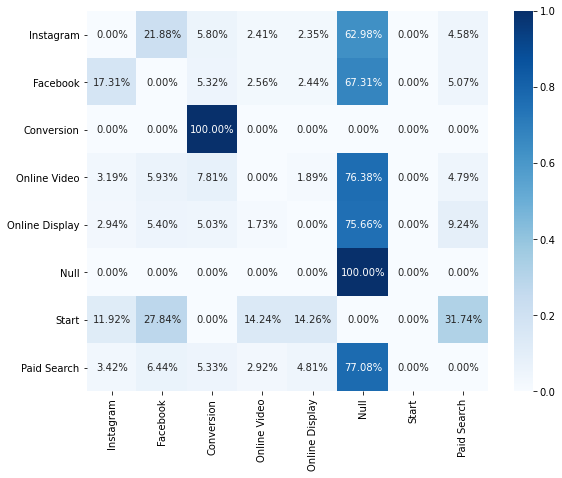

In [68]:
g = sns.heatmap(trans_matrix, annot=True, fmt='.2%', cmap='Blues')
g.figure.set_size_inches(9, 7)

Start에서 Paid Search로 가는 경향이 있음<br>
Instagram에서 Facebook으로 가는 경향이 있음

# 각 채널의 제거 효과(Removal Effect)를 구해보자

In [72]:
channels = [column for column in trans_matrix.columns if column not in ['Start', 'Null', 'Conversion']]
channels

['Instagram', 'Facebook', 'Online Video', 'Online Display', 'Paid Search']

### Facebook 제거 효과를 구해보자
* Facebook으로 인한 전환이 다 없어졌다고 가정했을 때 전체 전환율을 구한다.
<br>
1) Facebook으로 인한 전환을 제거하는 일<br>
2) 제거된 상태에서 전체 전환율을 다시 계산해 보는 일

In [91]:
channel = 'Facebook'
removal = trans_matrix.drop(channel, axis=0).drop(channel, axis=1)
removal

,Instagram,Conversion,Online Video,Online Display,Null,Start,Paid Search
Instagram,0.000000,0.057979,0.024118,0.023531,0.629786,0.0,0.045809
Conversion,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000
Online Video,0.031908,0.078146,0.000000,0.018920,0.763757,0.0,0.047947
Online Display,0.029363,0.050324,0.017299,0.000000,0.756643,0.0,0.092386
Null,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000
Start,0.119188,0.000000,0.142361,0.142644,0.000000,0.0,0.317399
Paid Search,0.034196,0.053309,0.029221,0.048053,0.770779,0.0,0.000000


전이 확률은 행으로 다 더했을 때 1이 되어야 하므로 Null에 부족한 확률에 더해준다.

In [94]:
for column in removal.columns:
    row_sum = np.sum(list(removal.loc[column]))
    null_pct = 1.0 - row_sum
    if null_pct != 0:
        removal.loc[column]['Null'] += null_pct
    removal.loc['Null']['Null'] = 1.0
removal

,Instagram,Conversion,Online Video,Online Display,Null,Start,Paid Search
Instagram,0.000000,0.057979,0.024118,0.023531,0.848563,0.0,0.045809
Conversion,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000
Online Video,0.031908,0.078146,0.000000,0.018920,0.823080,0.0,0.047947
Online Display,0.029363,0.050324,0.017299,0.000000,0.810628,0.0,0.092386
Null,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000
Start,0.119188,0.000000,0.142361,0.142644,0.278408,0.0,0.317399
Paid Search,0.034196,0.053309,0.029221,0.048053,0.835221,0.0,0.000000


In [101]:
column = 'Instagram'
list(removal.loc[column]), np.sum(list(removal.loc[column]))

([0.0,
  0.057979218048760765,
  0.024117575708567502,
  0.023531314438199977,
  0.8485626490923058,
  0.0,
  0.04580924271216593],
 1.0)

맨 처음 Start에서 시작해서 어떤 state를 다 거치고 오더라도<br>
결과적으로 Conversion으로 가는 확률값 = Facebook을 제거했을 때 Start에서 시작한 최종적인 전환율<br>
<br>
Absorbing States: Null or Conversion<br>
Transition States: 변화하는 States 나머지 Start에서 각 Channel

In [105]:
removal_to_conv = removal[['Null', 'Conversion']].drop(['Null', 'Conversion'], axis=0)
removal_to_conv # R

,Null,Conversion
Instagram,0.848563,0.057979
Online Video,0.823080,0.078146
Online Display,0.810628,0.050324
Start,0.278408,0.000000
Paid Search,0.835221,0.053309


In [106]:
removal_to_non_conv = removal.drop(['Null', 'Conversion'], axis=1).drop(['Null', 'Conversion'], axis=0)
removal_to_non_conv # Q

,Instagram,Online Video,Online Display,Start,Paid Search
Instagram,0.000000,0.024118,0.023531,0.0,0.045809
Online Video,0.031908,0.000000,0.018920,0.0,0.047947
Online Display,0.029363,0.017299,0.000000,0.0,0.092386
Start,0.119188,0.142361,0.142644,0.0,0.317399
Paid Search,0.034196,0.029221,0.048053,0.0,0.000000


$\bar{P} = \begin{bmatrix}
I & 0 \\
FR & 0 \\
\end{bmatrix}$

$F = (I - Q)^{-1}$

In [115]:
R = np.array(removal_to_conv)
R

array([[0.84856265, 0.05797922],
       [0.82307993, 0.0781456 ],
       [0.81062811, 0.05032391],
       [0.27840805, 0.        ],
       [0.83522062, 0.05330932]])

In [110]:
I = np.identity(len(removal_to_non_conv.columns))
I

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [111]:
Q = np.array(removal_to_non_conv)
Q

array([[0.        , 0.02411758, 0.02353131, 0.        , 0.04580924],
       [0.03190762, 0.        , 0.01891997, 0.        , 0.04794688],
       [0.02936344, 0.01729885, 0.        , 0.        , 0.09238569],
       [0.11918803, 0.14236094, 0.14264414, 0.        , 0.31739884],
       [0.03419631, 0.02922107, 0.04805268, 0.        , 0.        ]])

In [113]:
F = np.linalg.inv(I - Q)
F

array([[1.00330901, 0.02610673, 0.0264894 , 0.        , 0.0496598 ],
       [0.03441676, 1.00272629, 0.02226629, 0.        , 0.05171129],
       [0.03346716, 0.02099524, 1.0057718 , 0.        , 0.09545869],
       [0.14097535, 0.15875911, 0.16562845, 1.        , 0.34677051],
       [0.03692335, 0.03120237, 0.04988651, 0.        , 1.00779629]])

In [117]:
removal_dot_prod = np.dot(F, R)
removal_dot_prod

array([[0.93580842, 0.06419158],
       [0.91576868, 0.08423132],
       [0.9407157 , 0.0592843 ],
       [0.95259886, 0.04740114],
       [0.93918547, 0.06081453]])

In [120]:
pd.DataFrame(removal_dot_prod, index=removal_to_conv.index, columns=removal_to_conv.columns)

,Null,Conversion
Instagram,0.935808,0.064192
Online Video,0.915769,0.084231
Online Display,0.940716,0.059284
Start,0.952599,0.047401
Paid Search,0.939185,0.060815


Start > Conversion: 0.047401(4.7%)

In [128]:
removal_cvr = pd.DataFrame(removal_dot_prod, index=removal_to_conv.index, columns=removal_to_conv.columns)[['Conversion']].loc['Start'].values[0]
removal_cvr

0.04740113808165116

In [130]:
base_conversion_rate

0.07346277508454528

전체 전환율 중 Facebook을 제거한 전환율의 비중은 다음과 같다

In [134]:
removal_cvr / base_conversion_rate

0.6452402325817279

In [136]:
removal_effect = 1.0 - (removal_cvr / base_conversion_rate)
removal_effect

0.3547597674182721

전환율이 35%가 사라질 수 있겠구나! (하지만 모든 채널의 효과를 구해서 다시 비중을 조정해야 한다.)

### 각 채널에 대한 제거효과 구하기

In [146]:
def removal_effects(df, conversion_rate):
    removal_effects_dict = {}
    channels = [column for column in trans_matrix.columns if column not in ['Start', 'Null', 'Conversion']]
    for channel in channels:
        removal = df.drop(channel, axis=1).drop(channel, axis=0)
        for column in removal.columns:
            row_sum = np.sum(list(removal.loc[column]))
            null_pct = 1.0 - row_sum
            if null_pct != 0:
                removal.loc[column]['Null'] = null_pct
            removal.loc['Null']['Null'] = 1.0

        removal_to_conv = removal[['Null', 'Conversion']].drop(['Null', 'Conversion'], axis=0)
        removal_to_non_conv = removal.drop(['Null', 'Conversion'], axis=1).drop(['Null', 'Conversion'], axis=0)

        R = np.array(removal_to_conv)
        Q = np.array(removal_to_non_conv)
        I = np.identity(len(removal_to_non_conv.columns))
        F = np.linalg.inv(I - Q)

        removal_dot_prod = np.dot(F, R)

        removal_cvr = pd.DataFrame(removal_dot_prod, index=removal_to_conv.index, columns=removal_to_conv.columns)[['Conversion']].loc['Start'].values[0]
        removal_effect = 1.0 - (removal_cvr / base_conversion_rate)
        removal_effects_dict[channel] = removal_effect
    return removal_effects_dict

In [148]:
removal_effects_dict = removal_effects(trans_matrix, base_conversion_rate)
removal_effects_dict

{'Instagram': 0.21731366149038456,
 'Facebook': 0.3547597674182721,
 'Online Video': 0.2069141165564219,
 'Online Display': 0.15435482356041275,
 'Paid Search': 0.3311037560086154}

In [150]:
re_sum = np.sum(list(removal_effects_dict.values()))
re_sum

1.2644461250341066

### 앞에서 구한 확률을 전체 확률로 나누고, 총 전환수에 곱한다.

* 각 제거 효과로 구한 확률의 비중만큼 전환에 대한 기여도를 재조정한다.

In [153]:
for k, v in removal_effects_dict.items():
    print(k, (v / re_sum) * conversion_count)

Instagram 3031.521548555893
Facebook 4948.892177847523
Online Video 2886.4480895461475
Online Display 2153.2469267590823
Paid Search 4618.891257291356


In [157]:
def markov_chain_allocations(removal_effects, total_conversions):
    re_sum = np.sum(list(removal_effects_dict.values()))
    return {k: (v / re_sum) * total_conversions for k, v in removal_effects.items()}

In [159]:
attributions = markov_chain_allocations(removal_effects_dict, conversion_count)
attributions

{'Instagram': 3031.521548555893,
 'Facebook': 4948.892177847523,
 'Online Video': 2886.4480895461475,
 'Online Display': 2153.2469267590823,
 'Paid Search': 4618.891257291356}

In [161]:
conversion_count

17639

In [163]:
sum(attributions.values())

17639.0

In [165]:
attribution_by_markov = pd.DataFrame({'channel': attributions.keys(), 'attribution': attributions.values()})
attribution_by_markov

,channel,attribution
0,Instagram,3031.521549
1,Facebook,4948.892178
2,Online Video,2886.448090
3,Online Display,2153.246927
4,Paid Search,4618.891257


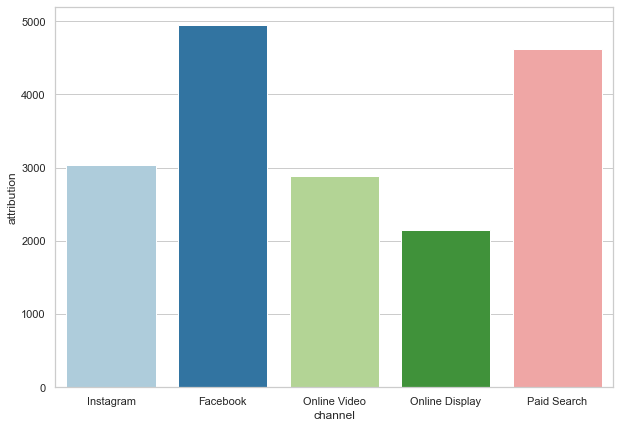

In [166]:
sns.set_theme(style='whitegrid', palette='Paired')
g = sns.barplot(x=attribution_by_markov.channel, y=attribution_by_markov.attribution, data=attribution_by_markov)
g.figure.set_size_inches(10, 7)

# 간단한 기여도 모델과 Markov Chain 모델로 구한 기여도 비교하기

In [168]:
df_last_interaction = df.drop_duplicates('cookie', keep='last')[['cookie', 'channel', 'conversion']]
df_last_interaction_conv = df_last_interaction[df_last_interaction.conversion == 1]
last_interaction_attrib = df_last_interaction_conv.groupby('channel')['cookie'].count().reset_index().rename(columns={'cookie': 'attribution'})
last_interaction_attrib['method'] = 'last'

df_first_interaction = df.drop_duplicates('cookie', keep='first')[['cookie', 'channel', 'conversion']]
df_first_interaction_conv = df_first_interaction.merge(df_last_interaction_conv[['cookie']], on='cookie')
first_interaction_attrib = df_first_interaction_conv.groupby('channel')['cookie'].count().reset_index().rename(columns={'cookie': 'attribution'})
first_interaction_attrib['method'] = 'first'

df_uniq_chl = df.drop_duplicates(['cookie', 'channel'], keep='last')[['cookie', 'channel']]
df_uniq_chl_cnt = df_uniq_chl.groupby('cookie').count().rename(columns={'channel': 'channel_cnt'}).reset_index()
df_uniq_chl_total = df_uniq_chl.merge(df_uniq_chl_cnt, on='cookie')
df_linear_interaction_conv = df_uniq_chl_total.merge(df_last_interaction_conv[['cookie', 'conversion']], on='cookie')
df_linear_interaction_conv['linear_attr'] = df_linear_interaction_conv.conversion.divide(df_linear_interaction_conv.channel_cnt)
linear_interaction_attrib = df_linear_interaction_conv.groupby('channel')['linear_attr'].sum().reset_index().rename(columns={'linear_attr':'attribution'})
linear_interaction_attrib['method'] = 'linear'

total_data = (
    last_interaction_attrib
    .append(first_interaction_attrib, ignore_index=True)
    .append(linear_interaction_attrib, ignore_index=True)
)
total_data

,channel,attribution,method
0,Facebook,5301.000000,last
1,Instagram,2244.000000,last
2,Online Display,2139.000000,last
3,Online Video,3408.000000,last
4,Paid Search,4547.000000,last
5,Facebook,5177.000000,first
6,Instagram,2329.000000,first
7,Online Display,2160.000000,first
8,Online Video,3216.000000,first
9,Paid Search,4757.000000,first


In [170]:
attribution_by_markov['method'] = 'markov'

In [171]:
total_with_markov = total_data.append(attribution_by_markov, ignore_index=True)

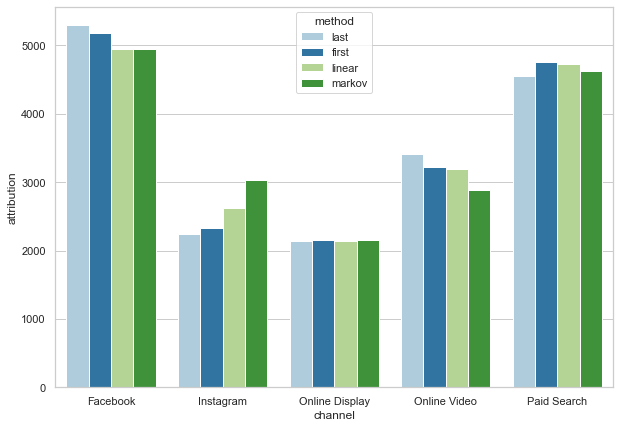

In [172]:
sns.set_theme(style='whitegrid', palette='Paired')
g = sns.barplot(x=total_with_markov.channel, y=total_with_markov.attribution, hue=total_with_markov.method)
g.figure.set_size_inches(10, 7)

Instagrm의 경우 markov의 기여도가 더 높음을 알 수 있다.